# Decompaction loop

As for exercise 3:

<div class="alert alert-block alert-success">
_Learning points_: decompaction is an important procedure to remove the progressive effects of compaction and reduction of layer thicknesses and average porosities during basin subsidence. Decompaction allows the depths of certain stratigraphic horizons to be tracked as a function of time. The decompaction technique essentially restores present-day thicknesses to those at a given time in the burial history by use of porosity-depth relationships for each lithological type. </div>

Instead of doing each layer decompaction step-by-step, we will write a function to do it automatically. 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import functools
from scipy.optimize import bisect
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.rcParams['mathtext.fontset'] = 'cm'

## Driving equations

**General decompaction equation**.

$$ y_2' - y_1' =  y_2- y_1 - \frac{\phi_0}{c} \left( e^{-cy_1} - e^{-cy_2}\right) + \frac{\phi_0}{c} \left( e^{-cy_1'} - e^{-cy_2'}\right) $$

**Average porosity of a layer at any depth**

$$ \phi = \frac{\phi_0}{c} \left[\frac{e^{-cy_1'} - e^{-cy_2'}}{y_2'-y_1'}\right]$$

## Problem definitions

<img src="figs/ex3-fig1.png" width="50%">

We consider the three-layer dataset defined by the above table. The procedure to decompact the different layers consist in an iterative process starting from the deepest layer to the top of the sedimentary pile.

<img src="figs/ex3-fig2.png" width="40%">

In [13]:
# Compaction function - the unknown variable is y2a
def comp_func(y2new,y1,y2,y1new,phi0,c):
    # left hand side of decompaction equation:
    LHS = y2new - y1new
    # right hand side of decompaction equation:
    RHS = y2 - y1 - (phi0/c)*(np.exp(-c*y1)-np.exp(-c*y2)) + (phi0/c)*(np.exp(-c*y1new)-np.exp(-c*y2new))
    return LHS - RHS

## Code to (de)compact a stratigraphic column with multiple layers

We write a function that does the depth calculation for more than one layer in a sedimentary column:

In [14]:
def decompact(tops, lith, new_top, phi_chalk, phi_sand, phi_shales, c_chalk, c_sand, c_shales):
    tops_new = [] # list for decompacted tops
    tops_new.append(new_top) # starting value
    for i in range(len(tops)-1):
        if lith[i] == 2:
            phi = phi_shales; c = c_shales
        if lith[i] == 1:
            phi = phi_sand; c = c_sand
        if lith[i] == 0:
            phi = phi_chalk; c = c_chalk
        comp_func_1 = functools.partial(comp_func,y1=tops[i],y2=tops[i+1],y1new=tops_new[-1],phi0=phi,c=c)
        base_new_a = tops_new[-1]+tops[i+1]-tops[i]
        base_new = bisect(comp_func_1, base_new_a, 4*base_new_a) # bisection
        tops_new.append(base_new)
    return tops_new

Let’s use this function to decompact the stratigraphic column that is describe above:

In [24]:
tops = np.array([2.,3.,4.])
lith = np.array([1,0])

phi0_chalk = 0.7
c_chalk = 0.71

phi0_sand = 0.49
c_sand = 0.27

phi0_shales = 0.63
c_shales = 0.51

In [25]:
tops_new = decompact(tops,lith,0.0,phi0_chalk, phi0_sand, phi0_shales, c_chalk, c_sand, c_shales) # compute new tops

In [27]:
print tops_new

[0.0, 1.2800793260707906, 2.4439470802009047]


Plotting the results

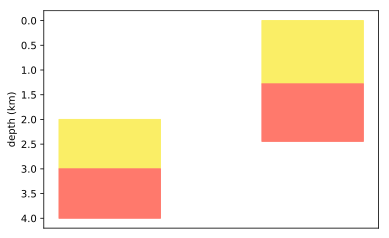

In [26]:
def plot_decompaction(tops,tops_new):
    for i in range(len(tops)-1):
        x = [0,1,1,0]
        y = [tops[i], tops[i], tops[i+1], tops[i+1]]
        if lith[i] == 0:
            color = 'xkcd:salmon'
        if lith[i] == 1:
            color = 'xkcd:yellowish'
        if lith[i] == 2:
            color = 'xkcd:umber'
        plt.fill(x,y,color=color)
        x = np.array([2,3,3,2])
        y = np.array([tops_new[i], tops_new[i], tops_new[i+1], tops_new[i+1]])
        if lith[i] == 0:
            color = 'xkcd:salmon'
        if lith[i] == 1:
            color = 'xkcd:yellowish'
        if lith[i] == 2:
            color = 'xkcd:umber'
        plt.fill(x,y,color=color)
    plt.gca().invert_yaxis()
    plt.tick_params(axis='x',which='both',bottom='off',top='off',labelbottom='off')
    plt.ylabel('depth (km)')

plot_decompaction(tops,tops_new)

<img src="figs/ex3-fig4.png" width="40%">

## Another example

In [37]:
tops = np.array([1.0,1.1,1.15,1.3,1.5,2.0])
lith = np.array([2,1,2,1,2]) # lithology labels: 2 = shale, 1 = sand
phi0_sand = 0.49 # surface porosity for sand
phi0_shale = 0.63 # surface porosity for mud
c_sand = 0.27 # porosity-depth coefficient for sand (km-1)
c_shale = 0.57 # porosity-depth coefficent for mud (km-1)
tops_new = decompact(tops,lith,0.0,phi0_chalk, phi0_sand, phi0_shales, c_chalk, c_sand, c_shales) # compute new tops

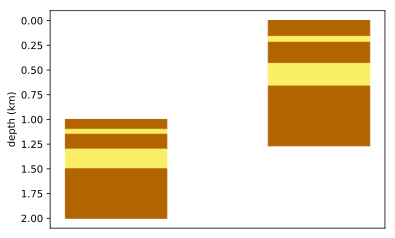

In [38]:
plot_decompaction(tops,tops_new)

In [39]:
print tops_new

[0.0, 0.15979553483812212, 0.2195157427494134, 0.4326842455826826, 0.6627910311003828, 1.2670569884144909]


<div class="alert alert-block alert-info">
**Now let’s see what happens if we use the 90% mud and 90% sand curves from Kominz et al. (2011) (based on ex2)**</div>

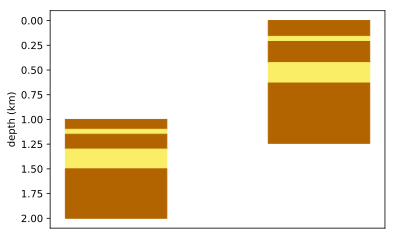

In [40]:
tops = np.array([1.0,1.1,1.15,1.3,1.5,2.0])
lith = np.array([2,1,2,1,2]) # lithology labels: 0 = mud, 1 = sand
c_sand = 1000/18605.0 # Kominz et al. 2011 >90% sand curve
c_shale = 1000/1671.0 # Kominz et al. 2011 >90% mud curve
phi0_sand = 0.407 # Kominz et al. 2011 >90% sand curve
phi0_shale = 0.614 # Kominz et al. 2011 >90% mud curve
tops_new = decompact(tops,lith,0.0,phi0_chalk, phi0_sand, phi0_shales, c_chalk, c_sand, c_shales) # compute new tops

plot_decompaction(tops,tops_new)

In [41]:
print tops_new

[0.0, 0.15979553483812212, 0.21145710595616155, 0.4255764523617469, 0.631566615475102, 1.2414721061450642]


Quite predictably, the main difference is that the sand layers have decompacted less in this case.